In [46]:
import pandas as pd
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.models import Model
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from utils import get_engine
from sklearn import linear_model
import matplotlib.pyplot as plt

In [88]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

In [116]:
# load dataset
table = "data_fraud_little"
engine = get_engine()
dataframe = pd.read_sql_query("select * from {table} limit 50000".format(table=table),engine)
dataset = dataframe.values
print("First one row of the dataset")
print("Shape [{}]".format(dataset.shape))
print(dataset[0:2,:])
# split into input (X) and output (Y) variables
data_dimensions = 45
#first dimension is the index, must be removed!!!!
X = dataset[:, 1:data_dimensions]
Y = dataset[:, data_dimensions]

print("Fraud {}% ".format(float(np.sum(Y==1))*100.0/Y.shape[0]))
print("Total #samples:",Y.shape[0])
Y = to_categorical(Y, nb_classes=None)


input_dimensions = X.shape[1]
print("shapes: X[{}]=====Y[{}]".format(X.shape, Y.shape))

First one row of the dataset
Shape [(50000, 47)]
[[  4.75200320e+07   7.49524000e+05   1.38868315e+18   6.89620000e+04
    5.83500000e+01   1.77484800e+06   5.77500000e+04   1.87362000e+05
    3.67000000e+02   1.62381800e+06   1.68885100e+06   5.20000000e+02
    5.00000000e+00   0.00000000e+00   0.00000000e+00   8.00000000e+00
    1.00000000e+00   0.00000000e+00   4.00000000e+00   0.00000000e+00
    1.00000000e+00   1.00000000e+02   0.00000000e+00   0.00000000e+00
    0.00000000e+00   5.60000000e+01   1.00000000e+00   1.00000000e+00
    0.00000000e+00   1.00000000e+00   3.00000000e+00   0.00000000e+00
    1.90000000e+01   1.84000000e+03   8.26000000e+02   6.10000000e+07
    5.83500000e+01   5.13265000e+03   7.50000000e+03   7.50000000e+03
    2.18985000e+03  -9.22337204e+18   1.38602880e+18   1.47048000e+03
    1.37419200e+18   0.00000000e+00  -9.22337204e+18]
 [  3.88424760e+07   6.72120000e+05   1.39431354e+18   1.00165000e+05
    1.49900000e+01   4.20536000e+05   1.32586000e+05   0.

In [111]:
# define base mode
def baseline_model():
    return logistic_regresion()
    # return linear_regression()


def keras_lin_reg():
    x = Input((None,input_dimensions))
    y = Dense(1,activation='linear')(x)
    model = Model(x,y,"Linear Regression")
    model.compile(loss='mse', optimizer='sgd')
    return model

def logistic_regresion():
    logistic = linear_model.LogisticRegression(solver='sag', n_jobs=-1,max_iter=500)
    return logistic
def linear_regression():
    lr = linear_model.LinearRegression(n_jobs=-1)
    return lr

def mlp_model(hidden=45,layers=1):
    # create model
    model = Sequential()
    model.add(Dense(input_dimensions, input_dim=input_dimensions, init='normal', activation='relu'))
    if hidden is not None:
        for l in range(layers):
            model.add(Dense(hidden))
    model.add(Dense(2, init='normal', activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

def mlp_model_wrap(hidden=100,layers=1):
    return mlp_model(hidden,layers)
# fix random seed for reproducibility

In [56]:
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasClassifier(build_fn=mlp_model, nb_epoch=100, batch_size=10000, verbose=1)))
estimators.append(('mlp', KerasClassifier(build_fn=mlp_model_wrap, nb_epoch=100, batch_size=10000, verbose=0)))
# estimators.append(('liner reg', KerasClassifier(build_fn=keras_lin_reg, nb_epoch=100, batch_size=100000, verbose=1)))
# estimators.append(('linear_reg', baseline_model()))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
print("Results:", results)
print("Results: %.24f (%.24f) ROC" % (results.mean(), results.std()))
print(pipeline)

Epoch 1/100
450/450 [==============================] - 0s - loss: 0.7122
Epoch 2/100
450/450 [==============================] - 0s - loss: 0.6921
Epoch 3/100
450/450 [==============================] - 0s - loss: 0.6730
Epoch 4/100
450/450 [==============================] - 0s - loss: 0.6546
Epoch 5/100
450/450 [==============================] - 0s - loss: 0.6367
Epoch 6/100
450/450 [==============================] - 0s - loss: 0.6191
Epoch 7/100
450/450 [==============================] - 0s - loss: 0.6016
Epoch 8/100
450/450 [==============================] - 0s - loss: 0.5842
Epoch 9/100
450/450 [==============================] - 0s - loss: 0.5667
Epoch 10/100
450/450 [==============================] - 0s - loss: 0.5491
Epoch 11/100
450/450 [==============================] - 0s - loss: 0.5314
Epoch 12/100
450/450 [==============================] - 0s - loss: 0.5136
Epoch 13/100
450/450 [==============================] - 0s - loss: 0.4957
Epoch 14/100
450/450 [=========================

In [126]:
estimators = []
estimators.append(('standardize', StandardScaler()))

estimators.append(('mlp', KerasClassifier(build_fn=mlp_model_wrap, batch_size=10000, verbose=0)))

pipeline = Pipeline(estimators)#
pipeline.set_params(mlp__layers=1)
pipeline.set_params(mlp__hidden=100)
pipeline.set_params(mlp__nb_epoch=30)

Pipeline(steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlp', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe63c999090>)])

In [123]:
mlp_model_wrap.__call__

<method-wrapper '__call__' of function object at 0x7fe63b2e46e0>

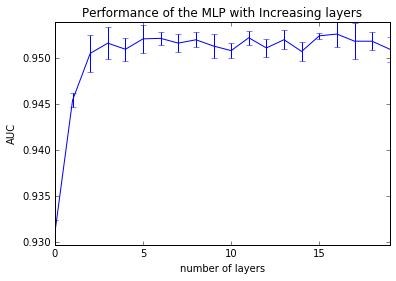

In [127]:
score_means_l = list()
score_stds_l = list()
layers = range(20)
kfold = KFold(n_splits=3, random_state=seed)
for l in layers:
    pipeline.set_params(mlp__layers=l) 
    this_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
    score_means_l.append(this_scores.mean())
    score_stds_l.append(this_scores.std())

title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers, score_means_l, np.array(score_stds_l))
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

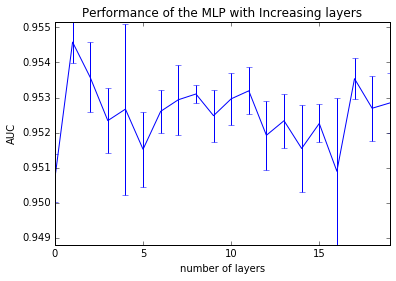

In [134]:
score_means_l = list()
score_stds_l = list()
layers = range(20)
kfold = KFold(n_splits=3, random_state=seed)
pipeline.set_params(mlp__nb_epoch=100)
for l in layers:
    pipeline.set_params(mlp__layers=l) 
    this_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
    score_means_l.append(this_scores.mean())
    score_stds_l.append(this_scores.std())

title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers, score_means_l, np.array(score_stds_l))
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [119]:
len(score_means_l)

9

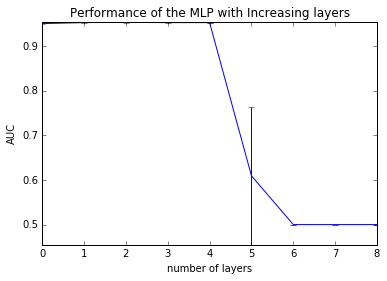

In [121]:
title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers[0:9], score_means_l, np.array(score_stds_l))
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

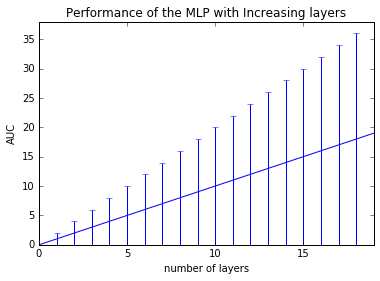

In [102]:
layers = range(20)
score_means = range(20)
score_stds = range(20)



title =  'Performance of the MLP with Increasing layers'
fig = plt.figure()
plt.errorbar(layers, score_means, np.array(score_stds))
hold on;
plt.title(title)
plt.xlabel('number of layers')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

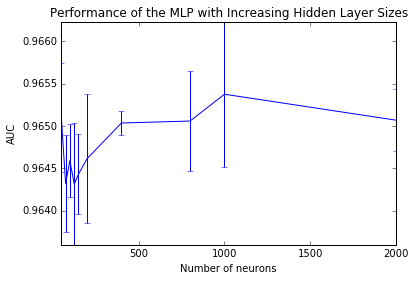

In [ ]:
score_means = list()
score_stds = list()
layers = [50,75,100,125,150,200,400,800,1000,2000]
kfold = KFold(n_splits=3, random_state=seed)
for l in layers:
    pipeline.set_params(mlp__hidden=l) 
    this_scores = cross_val_score(pipeline, X, Y, cv=kfold, scoring='roc_auc',n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())
title = "Performance of the MLP with Increasing Hidden Layer Sizes"
fig = plt.figure()
plt.errorbar(layers, score_means, np.array(score_stds))
plt.title(title)
plt.xlabel('Number of neurons')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

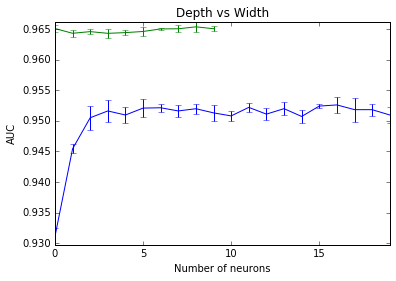

In [133]:
##TODO
layers = range(20)
title = "Depth vs Width"
fig = plt.figure()
plt.errorbar(layers, score_means_l, np.array(score_stds_l))
# layers = [50,75,100,125,150,200,400,800,1000,2000]
layers = range(10)
plt.errorbar(layers, score_means, np.array(score_stds))
plt.title(title)
plt.xlabel('Number of neurons')
plt.ylabel('AUC')

plt.axis('tight')
plt.show()

fig.savefig("/home/botty/Documents/CCFD/figures/analysis/"+title)

In [132]:
score_means

[0.96509850353803583,
 0.96432110658286907,
 0.96459139549372297,
 0.96431339234768265,
 0.96443099137947585,
 0.96461352025742786,
 0.96503427906738759,
 0.96505747394499242,
 0.96537370378549081,
 0.96506753180677673]

In [75]:
pipeline.fit(X,Y)

array([[  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   4.15100703e-38],
       [  7.50741765e-16,   1.00000000e+00],
       [  1.00000000e+00,   1.28349090e-31],
       [  1.03367141e-12,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   3.44401818e-19],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.68958149e-17],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.80259693e-45],
       [  1.00000000e+00,   0.00000000e+00],
       [  9.46300762e-16,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.63881516e-35],
       [  2.88253332e-16,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.29693489e-12],
       [  1.00000000e+00,   2.99683493e-23],
       [  

In [79]:
y_pred = pipeline.predict_proba(X)

In [86]:
y_pred[0:50,:]

array([[  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   4.15100703e-38],
       [  7.50741765e-16,   1.00000000e+00],
       [  1.00000000e+00,   1.28349090e-31],
       [  1.03367141e-12,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   3.44401818e-19],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.68958149e-17],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   2.80259693e-45],
       [  1.00000000e+00,   0.00000000e+00],
       [  9.46300762e-16,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   7.63881516e-35],
       [  2.88253332e-16,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00],
       [  1.00000000e+00,   1.29693489e-12],
       [  1.00000000e+00,   2.99683493e-23],
       [  

In [89]:
target_names = ["Genuine", "Fraud"]
y_test = Y
fpr,tpr,tresholds = roc_curve(y_test[:,0],y_pred[:,0])
print(auc(fpr, tpr))
# print(classification_report(y_test, y_pred, target_names=target_names))
# print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

1.0


In [90]:
fpr,tpr

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.90909091,  1.        ]),
 array([ 0.95981087,  0.96690307,  0.97635934,  1.        ,  1.        ,  1.        ]))